# Data Analysis Interview Challenge

This is the take-home challenge as part of the Springboard curriculum. This challenge consists of 3 parts:

* [1. EDA](#eda)
    * [1.1 15-minute Intervals](#1-15m)
    * [1.2 Visualizations](#1viz)
    * [1.3 Conclusions](#1con)
* [2. Experiment and Metrics Design](#design)
    * [2.1 Metric](#2metric)
    * [2.2 Experiment](#2exp)
* [3. Predictive Modeling](#pred)
    * [3.1 What fraction of users retained?](#3frac)
        * [3.1.1 Cleaning](#3clean)
        * [3.1.2 EDA](#3eda)
    * [3.2 Build a Predictive Model](#3model)
    * [3.3 Suggestions](#3conc)

## 1. EDA <a name='eda'></a>
* Aggregate login counts from `logins.json` based on 15-minute time intervals
* Visualize and describe the resulting time series, best describing the underlying patterns of the demand
* Illustrate important features of the demand like daily cycles
* If there are any data quality issues, report them

In [165]:
#Import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import json
from datetime import datetime as dt

import statsmodels.api as sm

In [166]:
import warnings
warnings.filterwarnings('ignore')

In [167]:
#Load relevant files
path = 'logins.json'
logins = pd.read_json(path)

Explore what the data initially looks like:

In [168]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [169]:
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [170]:
#Check for missing values
logins.isna().sum()

login_time    0
dtype: int64

### Aggregate the logins by 15-minute intervals <a name='1-15m'></a>

In [171]:
#Create new dataframe with logins by 15-minute intervals
logins_15 = logins.resample('15T', on='login_time').count()

#Rename column to count
logins_15 = logins_15.rename(columns={'login_time':'count'})

In [172]:
logins_15.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


### Visualizations <a name='1viz'></a>

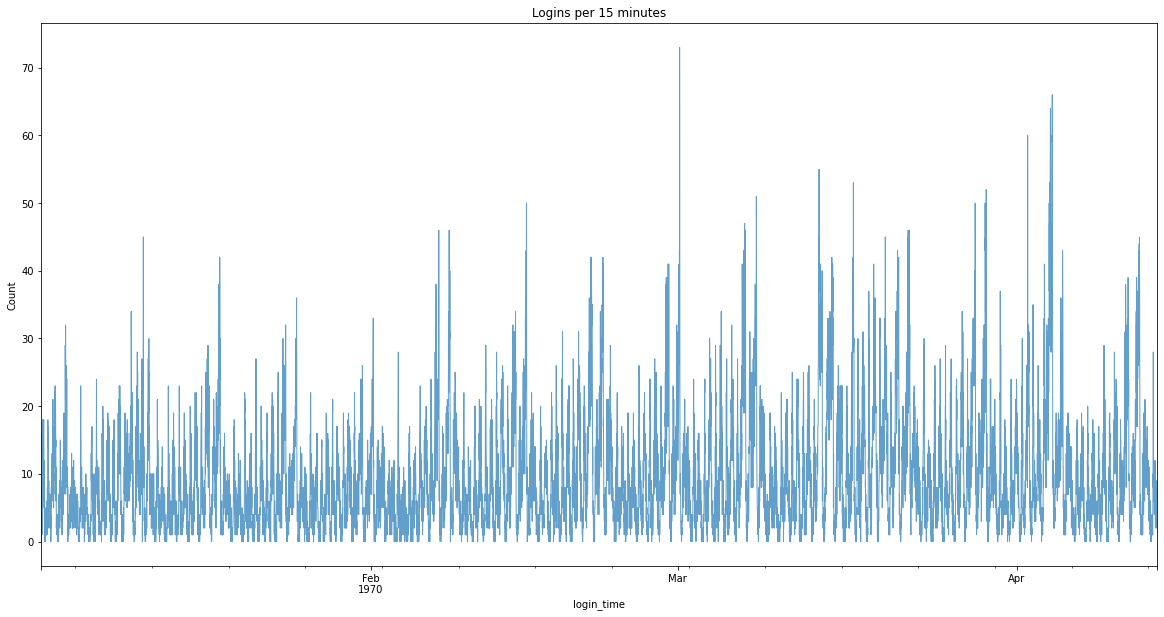

In [173]:
#Plot the overall 15-minute login counts
logins_15.plot(figsize=(20,10), lw=1, legend=False, alpha=0.7)
plt.ylabel('Count')
plt.title('Logins per 15 minutes')
plt.show()

There seems to be some cycles but it's still too noisy to really be sure. I'll plot the logins by month to see if it's easier to see anything.

In [174]:
#Add monthly, daily, weekly information to dataframe
logins_15['Month'] = logins_15.index.month
logins_15['Week'] = logins_15.index.week
logins_15['Day'] = logins_15.index.day
logins_15['Day_of_Week'] = logins_15.index.dayofweek

#Create a Weekday column that translates the Day_of_Week to a string weekday
weekdays = {0:"Mon", 1:"Tue", 2:"Wed", 3:"Thu", 4:"Fri", 5:"Sat", 6:"Sun"}
logins_15['Weekday'] = logins_15.Day_of_Week.replace(to_replace=weekdays)

In [175]:
logins_15

,count,Month,Week,Day,Day_of_Week,Weekday
login_time,,,,,,
1970-01-01 20:00:00,2,1,1,1,3,Thu
1970-01-01 20:15:00,6,1,1,1,3,Thu
1970-01-01 20:30:00,9,1,1,1,3,Thu
1970-01-01 20:45:00,7,1,1,1,3,Thu
1970-01-01 21:00:00,1,1,1,1,3,Thu
...,...,...,...,...,...,...
1970-04-13 17:45:00,5,4,16,13,0,Mon
1970-04-13 18:00:00,5,4,16,13,0,Mon
1970-04-13 18:15:00,2,4,16,13,0,Mon


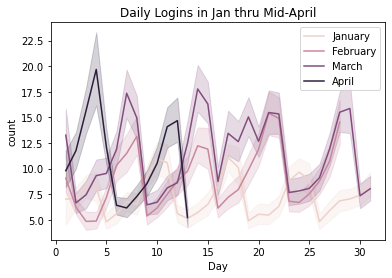

In [176]:
#Plot monthly data
sns.lineplot(x='Day', y='count', hue='Month', data=logins_15)
plt.title('Daily Logins in Jan thru Mid-April')
plt.legend(['January', 'February', 'March', 'April'])
plt.show()

There doesn't seem to be a lot of relation between each month necessarily but there are periodic spikes in logins, so taking at the weekly data might be a better approach. Not sure what happened in the second week of March to create unusual logins.

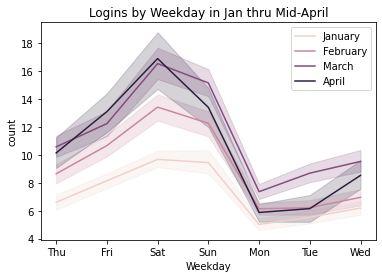

In [177]:
#Plot weekly data
sns.lineplot(x='Weekday', y='count', hue='Month', data=logins_15)
plt.title('Logins by Weekday in Jan thru Mid-April')
plt.legend(['January', 'February',  'March', 'April'])
plt.show()

There seems to be a trend over the week, with most people logging in during the weekend and towards the weekend; the least amount of people generally logging in on Monday. 

There also seems to be a general increase in logins over the months, with higher logins on Saturdays especially. To confirm this, I'd like to look at the data without its weekly trend. 

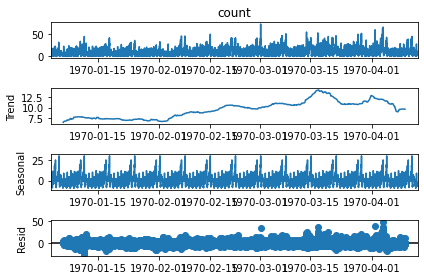

In [178]:
#Create data with seasonal decomposition
#1 week period = 7*24*4 increments of 15-mins
sd = sm.tsa.seasonal_decompose(logins_15['count'], period=7*24*4)

#Plot the seasonal decomposition
sd.plot()
plt.show()

There is definitely a general increase in logins (and a small decrease). I imagine there's also a cycle in the daily data, since most people tend to be asleep during the night and would be less likely to login, assuming that the website gets most of its traffic from users in one time region.

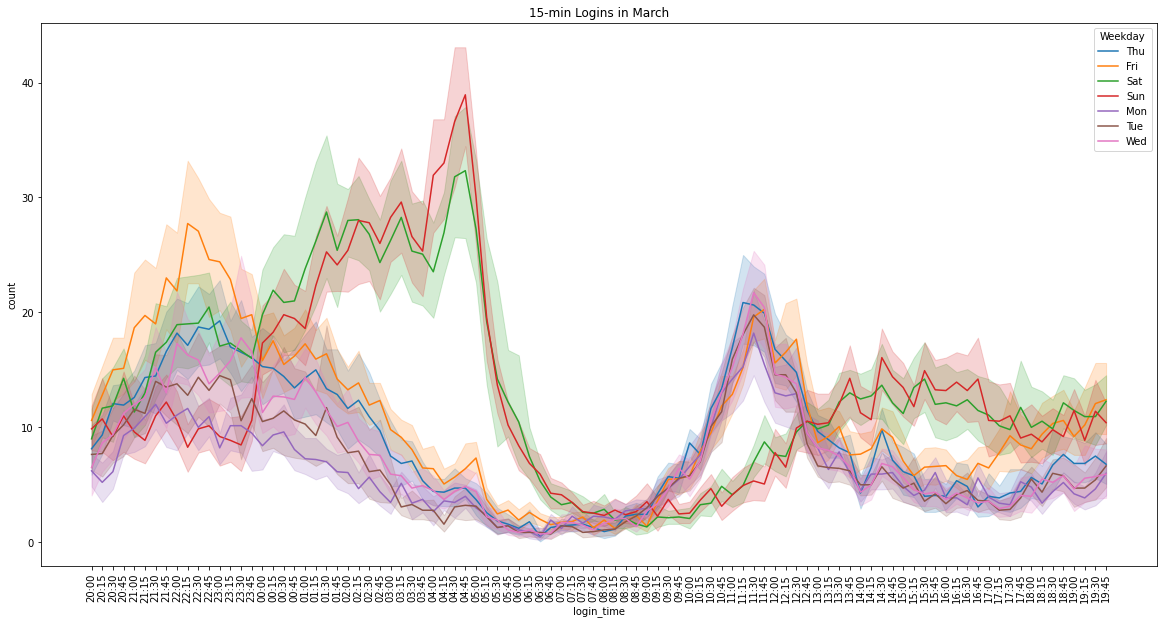

In [179]:
#Plot daily data
fig, ax = plt.subplots(figsize=(20, 10))

sns.lineplot(ax=ax, x=logins_15.index.strftime('%H:%M'), y='count', hue='Weekday', data=logins_15)
plt.title('15-min Logins in March')
plt.xticks(rotation=90)
plt.show()

There also seems to be a trend during the day, and as we're already aware, with two distinct groups: the weekend and the weekday. 

### Conclusions <a name='1con'></a>

The data shows that there is not just a weekly trend, but also a daily trend in logins.

On the weekdays, there's low login activity during the morning and afternoons with a peak around lunch time (11:15 - 11:30am). This is followed by an increase in logins during the evening; activity gradually elevates after 6pm and peaks at around 10:15pm. This makes sense since a lot of people work during the day with only time available during their lunch breaks or in the evening after work. Then people sleep at night which explains the low activity from 4:30 - 9am.

On the weekends, there seems to an overall increase in activity. With a slower gradual increase in the mornings to afternoon, reaching a plateau at around 1:30 - 4:45pm. The logins during this time are lower than peak activity during weekday lunch breaks, but lasts longer and doesn't decrease as much during the evening. After 8pm, weekend logins escalate and reaches its maximum at around 4:45am - 5am. Activity drops to baseline by around 6:30am. This also makes sense since people tend to sleep in and stay up later during the weekends.

Overall, there is a growth in login activity over the months. January is a bit slow. February shows a steady increase, and activity seems to peak in mid-March. This is followed by a small activity decline in April.

## 2. Experiment and Metrics Design<a name='design'></a>
* Gotham and Metropolis have complementary circadian rhythms: weekdays - gothem active at night while metropolis active during the day
* Driver partners are exclusive to each city
* Encourage driver partners to be available for both cities by reimbursing all toll costs

### What would be the key measure of success and why? <a name='2metric'></a>

There is an assumption that the cost isn't an issue; with the reimbursed toll costs, it doesn't cost more for the driver partner to cross to the other city than to stay in the current one. This is a reasonable assumption since activity is complementary most days of the week. 

The key metrics that I would then choose would be: 1) the amount of time the driver partner spends in each city; and 2) the amount of money the driver partner earns in each city.

An increase in time spent in both cities, especially for the non-native city, would meet the objective of encouraging driver partners to be available for both cities. However, increasing time does not necessarily mean that the drivers are successfully making trips and earning money. Additionally, longer trips does not always necessarily mean more money. As such, it's important to also compare the amount that the drivers earn in each city. Because in the long-run, drivers will not continue to cross to the next city if they are not earning more money, despite the reimbursed toll costs.

### Design a practical experiment to compare the effectiveness<a name='2exp'></a>
(Should include implementation, what statistical test, interpretability, recommendations, limitations)

Two A/B testing experiments will be conducted where a fraction of the driver population (randomized) will participate. A randomized half of these driver partners will be notified about the reimbursement plan and that they are encouraged to go into the adjacent city for more passengers (Group A). The other half will be the control group (Group B). The experiment will run for three to six months, depending on funding, so that the initial increase in activity due to curious experimentation of the drivers is taken into account.

For the first A/B test, the null hypothesis would state that there is no significant difference between the the time spent working in each city for groups A and B, after the initial month. The second A/B test's nulll hypothesis would state that there is no significant difference between the revenue earned by the grouops after the first month. 

A permutation test will be used for the weekly time spent and weekly revenue of the two groups to see when the p-value of group A is higher than group B's. If the p-value is small enough with 95% confidence, we can reject the null hypothesis and conclude that it's likey that the reimbursement plan worked. 

On the other hand, if the p-value is not small enough, the plan and the experiment may need readjusting. I would hesitate to stop the plan immediately; perhaps extend the experimentation duration so that it's more certain that drivers are comfortable going into the other city, comfortable with the roads, times, and customers in the new area. A feedback survey could be done for those in group A to understand why they weren't keen on making the drive to the next city.

All this to say that even if the p-value meets its target and the plan is a success, depending on the revenue earned for the company as well as any qualitative feedback obtained from the driver partners, it may not be worthwhile to implement the plan permanently. More discussions and possibly additional experimentation (e.g., a temporary test run for all drivers) would be needed.

## 3. Predictive Modeling<a name='pred'></a>
* Predict rider retention (retained if they were 'active' = took a trip in the previous 30 days)
* What factors are the best predictors for retention and offer suggests for operations

This is a supervised binary classification model.

### Cleaning, EDA, Visualizations: What fraction of observed users were retained? <a name='3frac'></a>
**Answer:** 37.61%

In [180]:
#Load the data
df = pd.read_json('ultimate_data_challenge.json')
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [181]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [182]:
#Change to datetime object
df['signup_date'] = pd.to_datetime(df['signup_date'], format='%Y-%m-%d')
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'], format='%Y-%m-%d')
print(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [183]:
#Check missing values
df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

I'm assuming that the current date is the last date in the data since there is no date stated.

In [184]:
# Data of when data was pulled
last_date = df['last_trip_date'].max()
last_date

Timestamp('2014-07-01 00:00:00')

So any person with trips made within the last 30 days from 7/01/14 would be considered 'retained'.

In [185]:
threshold = df.last_trip_date.max() - pd.to_timedelta(30, unit='d')
threshold

Timestamp('2014-06-01 00:00:00')

In [186]:
# Create target column
df['active'] = df.last_trip_date >= threshold
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False


In [187]:
print("{:.2f}% of users who signed up in Jan 2014 were retained.\nIn other words, {:,.0f} users took a trip in the last 30 days.".format(df.active.mean()*100, len(df)*df.active.mean()))

37.61% of users who signed up in Jan 2014 were retained.
In other words, 18,804 users took a trip in the last 30 days.


#### Data Cleaning <a name='3clean'></a>

I want to take care of the missing values first. I will create a new column denoting that some values were missing, to not lose the value in the missing features. And if possible, I will fill in those missing values with the mean.

For the phones feature, I will create a separate np.NaN category.

In [188]:
df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
active                       0
dtype: int64

In [189]:
df.phone.unique()

array(['iPhone', 'Android', None], dtype=object)

In [190]:
#Quantify categorical variables and create new cat for NaN
df['phone'] = df.phone.replace({'iPhone':0, 'Android':1, np.NaN: 2})

In [191]:
#Create a function to create new columns marking any missing values
def isna_col(df, col_name, inplace=False):
    """Creates new columns in the dataframe to denote any missing values.
    Missing values will be represented as 1. 
    """
    if (inplace==False):
        new_df = df.copy()
    else:
        new_df = df
    
    #Select the missing values
    if col_name == 'phone':
        isna = new_df['phone']==2
    else:
        isna = new_df[col_name].isna()
        
    #Create new column to denote missing values
    new_colname = col_name + '_isna'
    new_df[new_colname] = 0
    
    #Fill missing values in new column with 1
    new_df.loc[isna, new_colname] = 1
    
    if(inplace==False):
        return new_df

In [192]:
#Create missing features columns
isna_col(df, 'avg_rating_of_driver', inplace=True)
isna_col(df, 'phone', inplace=True)
isna_col(df, 'avg_rating_by_driver', inplace=True)

df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active,avg_rating_of_driver_isna,phone_isna,avg_rating_by_driver_isna
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,0,15.4,True,46.2,3.67,5.0,True,0,0,0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,1,0.0,False,50.0,8.26,5.0,False,0,0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,0,0.0,False,100.0,0.77,5.0,False,0,0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,0,20.0,True,80.0,2.36,4.9,True,0,0,0
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,1,11.8,False,82.4,3.13,4.9,False,0,0,0


In [193]:
#Now to fill the NaN values with the means
df = df.fillna(df.mean())
df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver         0
avg_surge                    0
last_trip_date               0
phone                        0
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver         0
active                       0
avg_rating_of_driver_isna    0
phone_isna                   0
avg_rating_by_driver_isna    0
dtype: int64

Now that the missing values are taken care of, I'll be one-hot encoding the categorical variables.

In [194]:
dummies = pd.get_dummies(df[['city','phone','ultimate_black_user']], drop_first=True)
df = df.drop(['city','phone','ultimate_black_user'], axis=1)
df = df.join(dummies)
df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,active,avg_rating_of_driver_isna,phone_isna,avg_rating_by_driver_isna,phone,ultimate_black_user,city_King's Landing,city_Winterfell
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,46.2,3.67,5.0,True,0,0,0,0,True,1,0
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,50.0,8.26,5.0,False,0,0,0,1,False,0,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,100.0,0.77,5.0,False,0,0,0,0,False,0,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,80.0,2.36,4.9,True,0,0,0,0,True,1,0
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,82.4,3.13,4.9,False,0,0,0,1,False,0,1


In [195]:
#Change the True/False into numbers
df.active.replace(to_replace={True: 1, False: 0}, inplace=True)
df.ultimate_black_user.replace(to_replace={True: 1, False: 0}, inplace=True)
df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,active,avg_rating_of_driver_isna,phone_isna,avg_rating_by_driver_isna,phone,ultimate_black_user,city_King's Landing,city_Winterfell
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,46.2,3.67,5.0,1,0,0,0,0,1,1,0
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,50.0,8.26,5.0,0,0,0,0,1,0,0,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,100.0,0.77,5.0,0,0,0,0,0,0,0,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,80.0,2.36,4.9,1,0,0,0,0,1,1,0
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,82.4,3.13,4.9,0,0,0,0,1,0,0,1


#### EDA <a name='3eda'></a>

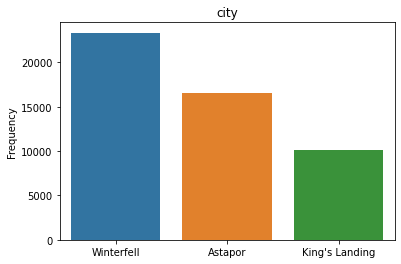

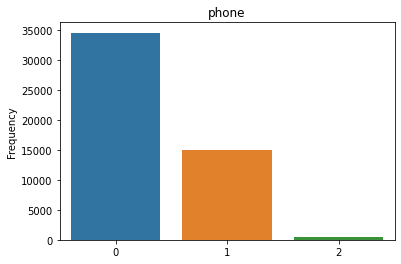

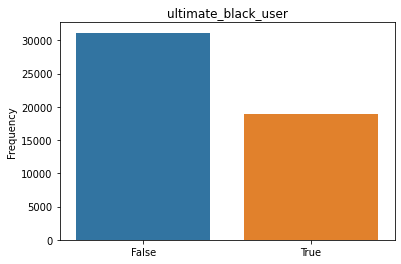

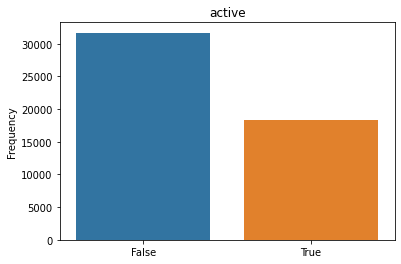

In [32]:
#Plot the categorical features
cats = ['city', 'phone', 'ultimate_black_user', 'active']

for category in cats:
    to_plot = df[category].value_counts()
    sns.barplot(x = list(to_plot.index), y=to_plot)
    
    plt.title(category)
    plt.ylabel('Frequency')
    plt.show()

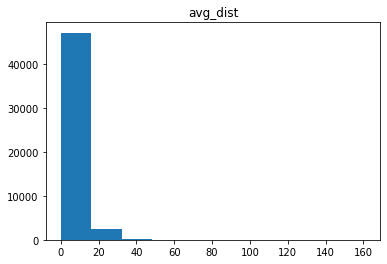

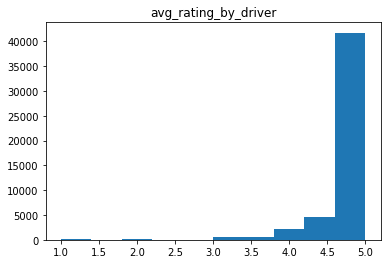

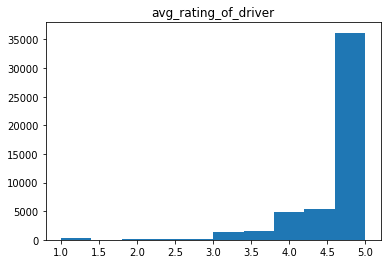

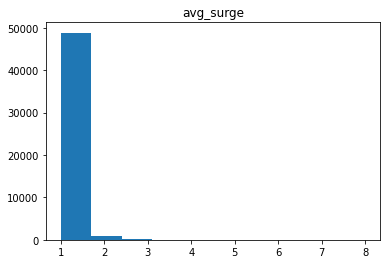

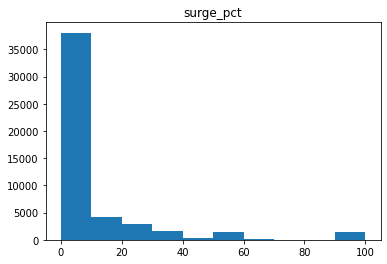

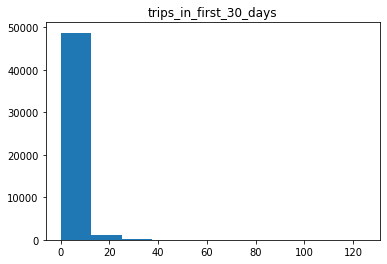

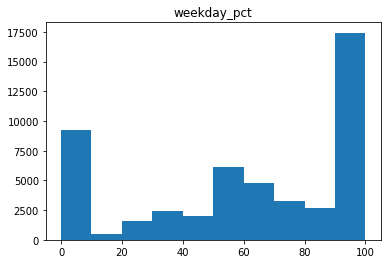

In [151]:
#Plot the numerical features
num_features = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver',
               'avg_surge', 'surge_pct', 'trips_in_first_30_days', 'weekday_pct']

for feature in num_features:
    plt.hist(df[feature])
    plt.title(feature)
    plt.show()

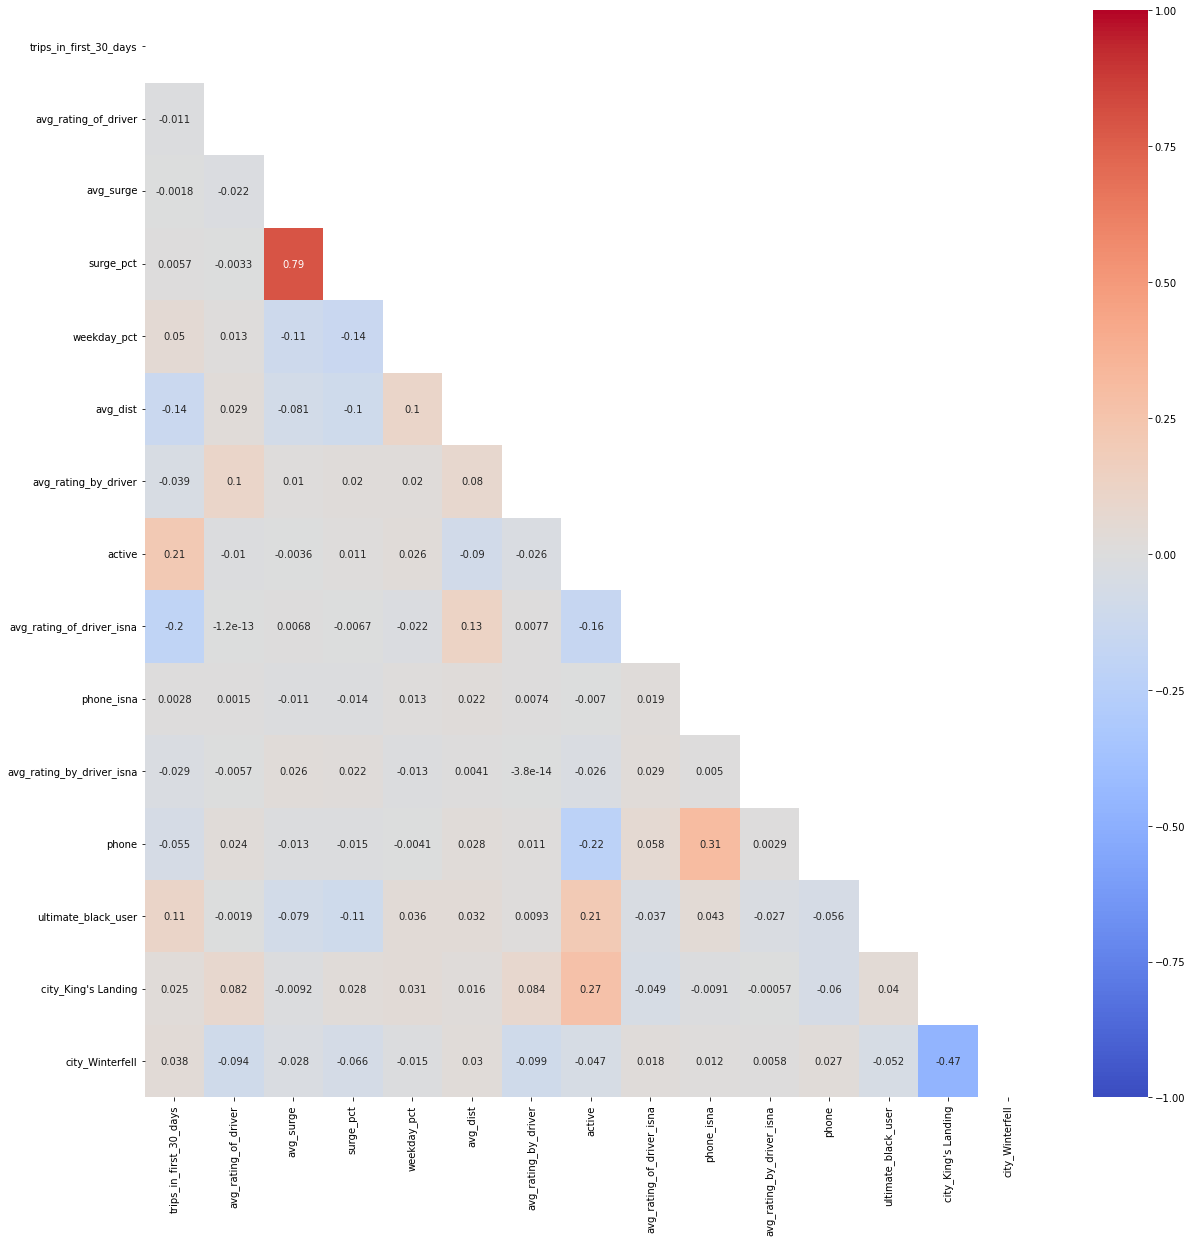

In [152]:
#Check for any correlations
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

fig, ax = plt.subplots(figsize=(20,20))
ax = sns.heatmap(corr, annot=True, mask=mask, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

In [153]:
df.corr()['active']

trips_in_first_30_days       0.214728
avg_rating_of_driver        -0.010082
avg_surge                   -0.003567
surge_pct                    0.010612
weekday_pct                  0.026413
avg_dist                    -0.090279
avg_rating_by_driver        -0.025595
active                       1.000000
avg_rating_of_driver_isna   -0.158274
phone_isna                  -0.007032
avg_rating_by_driver_isna   -0.025985
phone                       -0.223108
ultimate_black_user          0.210259
city_King's Landing          0.268272
city_Winterfell             -0.046985
Name: active, dtype: float64

Most features seem to have a negative correlation, with trips in King's Landing having the highest correlation.

### Build a predictive model: Will a user be active in their 6th month?<a name='3model'></a>
* Discuss approach, alternatives, concerns
* How valid is the model? 
* Include key indicators of model performance

In [100]:
#Loading relevant libraries
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import f1_score, accuracy_score, plot_confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score

In [51]:
import warnings
warnings.filterwarnings('ignore')

In [52]:
df.active.value_counts()

0    31690
1    18310
Name: active, dtype: int64

Since there's clearly a class imbalance (36% to 64%), the classes need to be stratified to account for this especially since we're aiming to maximize the accuracy of the model. Because of this reason, I'll also be looking at the ROC/AUC and the f1-score on top of accuracy as the evaluation metrics.

In [55]:
X = df.drop(['signup_date', 'last_trip_date','active'], axis=1)
y = df[['active']]

#Split the train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [95]:
cat_features = [col for col in X_train.columns.tolist() if col not in num_features]

#Build a pipeline to scale numerical variables
pipeline = ColumnTransformer([('num', StandardScaler(), num_features),
                            ('cat', 'passthrough', cat_features)])

X_train_ = pipeline.fit_transform(X_train)
X_test_ = pipeline.transform(X_test)

In [97]:
assert (len(X_train_[0])) == (len(X_train.columns)), 'Columns not matching!'

Now that the train and test sets are separated, I'll be doing an initial modeling to see which ones are worth spending more time on to fine tune later. I'll be experimenting with LogisticRegression, RandomForest, XGBClassifier, SVM. I'll also be creating a benchmark with LogisticRegression that'll be predicting the majority class every time.

In [110]:
#Create a benchmark
dummy_clf = DummyClassifier(strategy='constant', constant=0)
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test_)

benchmark = {}
benchmark['accuracy'] = accuracy_score(y_test, y_pred)
benchmark['f1'] = f1_score(y_test, y_pred)
benchmark['roc_auc_scores'] = roc_auc_score(y_test, y_pred)

benchmark

{'accuracy': 0.6338, 'f1': 0.0, 'roc_auc_scores': 0.5}

In [87]:
#Initial modeling
log_clf = LogisticRegression(random_state=42)
rf_clf = RandomForestClassifier(random_state=42)
gb_clf = GradientBoostingClassifier(random_state=42)
svm_clf = SVC(random_state=42)

#Create a dict to store the models
models_dict = {}

models_dict['Logistic Regression'] = log_clf
models_dict['Random Forest'] = rf_clf
models_dict['Gradient Boost'] = gb_clf
models_dict['SVM'] = svm_clf

In [92]:
def model_select(X, y, models, k_folds):
    """Collect the metrics for a model to select which ones to spend time fine tuning."""
    model_results = {}
    
    for model_name, model in models.items():
        metrics = {}
        
        cv = StratifiedKFold(n_splits = k_folds)
        accuracy_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
        
        metrics['accuracy'] = np.mean(accuracy_scores)
        
        f1_scores = cross_val_score(model, X, y, cv=cv, scoring='f1')
        metrics['f1'] = np.mean(f1_scores)
                
        roc_auc_scores = cross_val_score(model,X, y, cv=cv, scoring='roc_auc')
        metrics['roc_auc_scores'] = np.mean(roc_auc_scores)
        
        model_results[model_name] = metrics
    
    return model_results

In [93]:
pd.DataFrame(model_select(X_train_, y_train, models=models_dict, k_folds=5))

,Logistic Regression,Random Forest,Gradient Boost,SVM
accuracy,0.728975,0.764225,0.790375,0.777375
f1,0.577132,0.672054,0.697200,0.662173
roc_auc_scores,0.774301,0.825348,0.855404,0.834309


In [99]:
benchmark

{'accuracy': 0.6338, 'f1': 0.0, 'roc_auc_scores': 0.5}

Thankfully all the initial models perform better than the benchmark. Since the Random Forest and Gradient Boosting models do the best, I will focus on fine tuning those.

In [104]:
rf_clf_tune = RandomForestClassifier(random_state=42)

#Create parameters for fine tuning
param_grid = {'n_estimators': [10,25,50,100,200],
              'max_depth': [None,1,3,5,10,25,50,100],
              'criterion': ['gini', 'entropy']
}

#Create randomizedgridsearchcv pipeline
rf_cv = RandomizedSearchCV(rf_clf_tune, param_grid, cv=5, scoring='roc_auc', random_state=42)

#Fit model on the training set
rf_cv.fit(X_train_, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 1, 3, 5, 10, 25, 50,
                                                      100],
                                        'n_estimators': [10, 25, 50, 100, 200]},
                   random_state=42, scoring='roc_auc')

In [105]:
#Print the best parameters and scores
print(rf_cv.best_params_)
print(rf_cv.best_score_)

{'n_estimators': 50, 'max_depth': 10, 'criterion': 'gini'}
0.8535248691722938


In [106]:
#Tune the hyperparameters of GradientBoosting
gb_clf_tune = GradientBoostingClassifier(random_state=42)

#Create parameters for fine tuning
param_grid = {'loss':['deviance', 'exponential'],
              'n_estimators':[10,25,50,100,200],
              'max_depth':[3,5,8],
              'max_features':[None, 'log2', 'sqrt'],
              'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2]
}

#Create randomizedgridsearchcv pipeline
gb_cv = RandomizedSearchCV(gb_clf_tune, param_grid, cv=5, scoring='roc_auc', random_state=42)

#Fit model on the training set
gb_cv.fit(X_train_, y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
                   param_distributions={'learning_rate': [0.01, 0.025, 0.05,
                                                          0.075, 0.1, 0.15,
                                                          0.2],
                                        'loss': ['deviance', 'exponential'],
                                        'max_depth': [3, 5, 8],
                                        'max_features': [None, 'log2', 'sqrt'],
                                        'n_estimators': [10, 25, 50, 100, 200]},
                   random_state=42, scoring='roc_auc')

In [107]:
#Print the best parameters and scores
print(gb_cv.best_params_)
print(gb_cv.best_score_)

{'n_estimators': 200, 'max_features': None, 'max_depth': 5, 'loss': 'exponential', 'learning_rate': 0.05}
0.8607880510448034


In [111]:
#Collect the evaluation metrics
def final_select(X, y, models):
    """Collect the metrics from the final selected models."""
    model_results = {}
    model_results['Benchmark'] = benchmark
    
    for model_name, model in models.items():
        metrics = {}
        
        #Get predictions
        y_pred = model.predict(X)
        
        #Collect metrics
        metrics['accuracy'] = accuracy_score(y, y_pred)
        metrics['f1'] = f1_score(y, y_pred)
        metrics['roc_auc_scores'] = roc_auc_score(y, y_pred)
        
        model_results[model_name] = metrics
    
    return model_results

In [113]:
#Get the final models metrics
fin_models = {'RandomForest': rf_cv.best_estimator_, 'GradientBoosting':gb_cv.best_estimator_}

compare = pd.DataFrame(final_select(X_test_, y_test, models=fin_models))
compare

,Benchmark,RandomForest,GradientBoosting
accuracy,0.6338,0.787000,0.791800
f1,0.0000,0.686026,0.698261
roc_auc_scores,0.5000,0.755006,0.763519


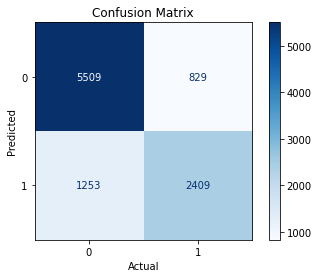

In [196]:
#Plot the confusion matrix
plot_confusion_matrix(gb_cv.best_estimator_, X_test_, y_test, cmap='Blues')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

Since GradientBoosting has the best performance, I'll look at the its feature importances.

In [114]:
gb_cv.best_estimator_.feature_importances_

array([0.05040645, 0.26541142, 0.01497247, 0.01590312, 0.14480522,
       0.05377994, 0.11350651, 0.01369103, 0.00090287, 0.00094436,
       0.08361485, 0.06562058, 0.15783064, 0.01861052])

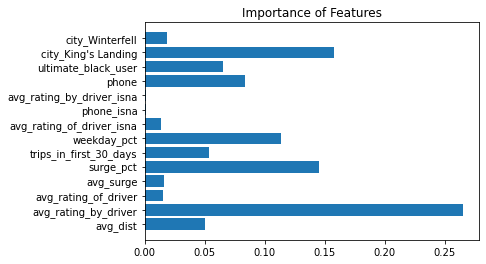

In [158]:
#Visualize which features are important
features = num_features + cat_features
plt.barh(features, gb_cv.best_estimator_.feature_importances_)
plt.title('Importance of Features')
plt.show()

### Suggestions for longterm rider retention <a name='3conc'></a>

In this project, we concluded that using a GradientBoostingClassifier (out of RandomForest, LogisticRegression, SVM) is the best predictor for whether a user will be retained after 6 months. This model has an accuracy rate of X%.

Looking at the factors that the model found most influential, there weren't any features that strongly suggested retention. However, it turns out that the average ratings by the driver is the biggest factor, followed by users in King's Landing and the percentage of trips taken with a surge multiplier. 

As such, perhaps Ultimate should focus its marketing during surge times, especially for customers in King's Landing since it looks like those customers are most likely to be retained. On the other hand, Ultimate could take the opposite approach to bump up its marketing and promotions for users in other areas so they are better retained, since those are their areas of opportunities and would most likely have the bigger revenue if done successfully.